In [2]:
from __future__ import print_function, division
import numpy as np
import os
import pandas as pd
import cv2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import mxnet as mx

In [3]:
def parse_voc_rec(filename):
    """
    parse pascal voc record into a dictionary
    :param filename: xml file path
    :return: list of dict
    """
    import xml.etree.ElementTree as ET
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_dict = dict()
        obj_dict['name'] = obj.find('name').text
        obj_dict['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_dict['bbox'] = [int(bbox.find('xmin').text),
                            int(bbox.find('ymin').text),
                            int(bbox.find('xmax').text),
                            int(bbox.find('ymax').text)]
        objects.append(obj_dict)
    return objects

def iou(x, ys):
    """
    Calculate intersection-over-union overlap
    Params:
    ----------
    x : numpy.array
        single box [xmin, ymin ,xmax, ymax]
    ys : numpy.array
        multiple box [[xmin, ymin, xmax, ymax], [...], ]
    Returns:
    -----------
    numpy.array
        [iou1, iou2, ...], size == ys.shape[0]
    """
    ixmin = np.maximum(ys[:, 0], x[0])
    iymin = np.maximum(ys[:, 1], x[1])
    ixmax = np.minimum(ys[:, 2], x[2])
    iymax = np.minimum(ys[:, 3], x[3])
    iw = np.maximum(ixmax - ixmin, 0.)
    ih = np.maximum(iymax - iymin, 0.)
    inters = iw * ih
    uni = (x[2] - x[0]) * (x[3] - x[1]) + (ys[:, 2] - ys[:, 0]) * \
        (ys[:, 3] - ys[:, 1]) - inters
    ious = inters / uni
    ious[uni < 1e-12] = 0  # in case bad boxes
    return ious

def read_index_file(fname):
    with open(fname) as f:
        content = f.readlines()
    return [x.strip() for x in content] 


def image_processing(img, data_shape=(300, 300)):
    img = cv2.resize(img, data_shape, interpolation=cv2.INTER_LINEAR)
    img_arr = np.asarray(img)
    img_arr = img_arr.copy()
#     img_arr[:, :, (0, 1, 2)] = img_arr[:, :, (2, 1, 0)]
    img_arr = img_arr.astype(float)
    pixel_means = [123, 117, 104]
    img_arr -= pixel_means
    channel_swap = (2, 0, 1)
    im_tensor = img_arr.transpose(channel_swap)
    im_tensor = im_tensor[np.newaxis, :]
    return im_tensor

def image_processing_sp(img, data_shape=(300, 300), pixel_means=[123, 117, 104]):
    img =  mx.img.imresize(img, 300, 300, cv2.INTER_LINEAR)
    img =  mx.nd.transpose(img, (2,0,1))
    img =  img.astype('float32')
    img -= mx.nd.array(pixel_means).reshape((len(pixel_means),1,1))
    img = mx.nd.expand_dims(img, axis=0)
    print (img.shape)
    return img

### FPPI vs miss rate RGB

In [184]:
# get pascal image and annotation 
img_dir = '../mxnet-ssd/data/pascal/VOC2007/JPEGImages/'
annotations = '../mxnet-ssd/data/pascal/VOC2007/Annotations/'

img_dir = '../mxnet-ssd/data/kaist/images/'
annotations = '../mxnet-ssd/data/kaist/annotations/'
test_set = read_index_file('../mxnet-ssd/data/kaist/image_sets/test.txt')

# rgb ssd
prefix = '../mxnet-ssd/model/resnet/deployed/deploy_ssd_300'
predictor_rgb = mx.model.FeedForward.load(prefix, 0, ctx=mx.gpu(0), numpy_batch_size=1)

In [193]:
FPPI_final = []
FNR_final = []

det_confidence = np.linspace(0.0, 1.0, num=20)

for score_th in det_confidence:
    FPPI = []
    FNR = []
    
#     for img in ['000200', '000282', '000288', '000477']:
    for img in test_set:

        # params
        gt = 0
        tp = 0
        fp = 0
        fn = 0
        
        gt_bboxs = []
        pr_bboxs = []
        
        img_data = np.load(img_dir+img+'.npy')
        img_data = img_data[:,:,:3]
        
#         img_data = cv2.imread(img_dir+img+'.jpg')
        height, width = img_data.shape[0], img_data.shape[1]
        bboxs = parse_voc_rec(annotations+img+'.xml')
        img_draw = img_data.copy()

        for bbox in bboxs:
            if bbox['name'] == 'person':
                x = bbox['bbox'][0]
                y = bbox['bbox'][1]
                xmax = bbox['bbox'][2]
                ymax =bbox['bbox'][3]
                cv2.rectangle(img_draw,(x,y),(xmax,ymax),(0,255,0), 2)
                gt+=1
                gt_bboxs.append([x,y,xmax,ymax])

        detections = predictor_rgb.predict(image_processing(img_data))[0, :, :]
        result = detections[np.where(detections[:, 0] >= 0)[0]]    

        # get only person class
        person_bbox = result[result[:, 0] == 14]

        # th predicted bboxes by confidence
        for i in range(person_bbox.shape[0]):
            score = person_bbox[i, 1]
            if score > score_th:
                xmin = int(person_bbox[i, 2] * width)
                ymin = int(person_bbox[i, 3] * height)
                xmax = int(person_bbox[i, 4] * width)
                ymax = int(person_bbox[i, 5] * height)
                cv2.rectangle(img_draw,(xmin, ymin),(xmax,ymax),(255,0,0), thickness=2)    
                pr_bboxs.append([xmin,ymin,xmax, ymax, score])

        # matching strategy 
        for pr_box in sorted(pr_bboxs, key=lambda x: x[4], reverse=True):
            # get all iou scores
            if len(gt_bboxs) == 0:
                fp+=1
                continue
            iou_scores = iou(np.array(pr_box), np.array(gt_bboxs))

            # take only >0.5
            ind_05 = [x for x in range(len(iou_scores)) if iou_scores[x] >= 0.5]

            # get only one perfect match 
            if len(ind_05) == 1:
                tp +=1
                # delete gt_bbox
                gt_bboxs.remove(gt_bboxs[ind_05[0]])

            # if several bboxes with ov>0.5 then take one with maximum overlap
            elif len(ind_05) > 1:
                f_ind = 0
                max_overlap = 0
                for i in ind_05:
                    current_overlap = iou_scores[i]  
                    if current_overlap > max_overlap:
                        max_overlap = current_overlap
                        f_ind = i
                tp +=1
                # delete gt_bbox
                gt_bboxs.remove(gt_bboxs[f_ind])

            # unmatched pr_box count as false positive    
            elif len(ind_05) == 0:
                fp+=1

#         img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
#         plt.imshow(img_draw)
#         plt.axis('off')
#         plt.show()

        # print info 
#         print('info')
#         print('gt', gt)
#         print('fn', gt-tp)
#         print('tp', tp)
#         print('fp', fp)
#         print('predicted bboxes', len(pr_bboxs))

        FPPI.append(fp+0.000001)
    #     FNR = FN/ (FN + TP) 
        FNR.append((gt-tp)/(gt+0.01))

        gt = 0
        fn = 0
        fp = 0
        tp = 0
        pr_bboxs = []
        gt_bboxs = []
    
    FPPI_final.append(np.array(FPPI).mean())
    FNR_final.append(np.array(FNR).mean())

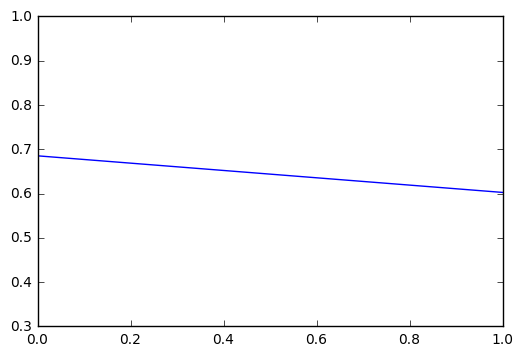

In [192]:
plt.figure()
plt.plot(np.log(FPPI_final), FNR_final)
axes = plt.gca()
axes.set_xlim([0,1])
plt.show()

### FPPI vs miss rate Spectral 

In [ ]:
# get kaist image and annotation 
img_dir = '../mxnet-ssd/data/pascal/VOC2007/JPEGImages/'
annotations = '../mxnet-ssd/data/pascal/VOC2007/Annotations/'

img_dir = '../mxnet-ssd/data/kaist/images/'
annotations = '../mxnet-ssd/data/kaist/annotations/'
test_set = read_index_file('../mxnet-ssd/data/kaist/image_sets/test.txt')

# rgb ssd
prefix = '../mxnet-ssd/model/resnet/deployed/deploy_ssd_300'
predictor_rgb = mx.model.FeedForward.load(prefix, 0, ctx=mx.gpu(0), numpy_batch_size=1)

In [9]:
prefix = '../mxnet-ssd/model/spectral/training_epochs/ssd_300'
predictor_spectral = mx.model.FeedForward.load(prefix, 18, ctx=mx.gpu(0), numpy_batch_size=1)

In [ ]:
predictor_spectral.predict()

In [12]:
# _, args, auxs = mx.model.load_checkpoint('../mxnet-ssd/model/spectral/training_epochs/ssd_300', 18)
# mod = mx.mod.Module(symbol, data_names=['rgb', 'tir'], label_names=None, context=mx.gpu(0))
# mod.bind(data_shapes=[('rgb', (1, 3, 300, 300)), ('tir', (1, 1, 300, 300))])
# mod.set_params(args, auxs)

In [ ]:
FPPI_final = []
FNR_final = []

det_confidence = np.linspace(0.0, 1.0, num=20)

for score_th in det_confidence:
    FPPI = []
    FNR = []
    
    for img in test_set:

        # params
        gt = 0
        tp = 0
        fp = 0
        fn = 0
        
        gt_bboxs = []
        pr_bboxs = []
        
        img_data = np.load(img_dir+img+'.npy')
        img_data = img_data[:,:,:3]
        
#         img_data = cv2.imread(img_dir+img+'.jpg')
        height, width = img_data.shape[0], img_data.shape[1]
        bboxs = parse_voc_rec(annotations+img+'.xml')
        img_draw = img_data.copy()

        for bbox in bboxs:
            if bbox['name'] == 'person':
                x = bbox['bbox'][0]
                y = bbox['bbox'][1]
                xmax = bbox['bbox'][2]
                ymax =bbox['bbox'][3]
                cv2.rectangle(img_draw,(x,y),(xmax,ymax),(0,255,0), 2)
                gt+=1
                gt_bboxs.append([x,y,xmax,ymax])

        detections = predictor_rgb.predict(image_processing(img_data))[0, :, :]
        result = detections[np.where(detections[:, 0] >= 0)[0]]    

        # get only person class
        person_bbox = result[result[:, 0] == 14]

        # th predicted bboxes by confidence
        for i in range(person_bbox.shape[0]):
            score = person_bbox[i, 1]
            if score > score_th:
                xmin = int(person_bbox[i, 2] * width)
                ymin = int(person_bbox[i, 3] * height)
                xmax = int(person_bbox[i, 4] * width)
                ymax = int(person_bbox[i, 5] * height)
                cv2.rectangle(img_draw,(xmin, ymin),(xmax,ymax),(255,0,0), thickness=2)    
                pr_bboxs.append([xmin,ymin,xmax, ymax, score])

        # matching strategy 
        for pr_box in sorted(pr_bboxs, key=lambda x: x[4], reverse=True):
            # get all iou scores
            if len(gt_bboxs) == 0:
                fp+=1
                continue
            iou_scores = iou(np.array(pr_box), np.array(gt_bboxs))

            # take only >0.5
            ind_05 = [x for x in range(len(iou_scores)) if iou_scores[x] >= 0.5]

            # get only one perfect match 
            if len(ind_05) == 1:
                tp +=1
                # delete gt_bbox
                gt_bboxs.remove(gt_bboxs[ind_05[0]])

            # if several bboxes with ov>0.5 then take one with maximum overlap
            elif len(ind_05) > 1:
                f_ind = 0
                max_overlap = 0
                for i in ind_05:
                    current_overlap = iou_scores[i]  
                    if current_overlap > max_overlap:
                        max_overlap = current_overlap
                        f_ind = i
                tp +=1
                # delete gt_bbox
                gt_bboxs.remove(gt_bboxs[f_ind])

            # unmatched pr_box count as false positive    
            elif len(ind_05) == 0:
                fp+=1

#         img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
#         plt.imshow(img_draw)
#         plt.axis('off')
#         plt.show()

        # print info 
#         print('info')
#         print('gt', gt)
#         print('fn', gt-tp)
#         print('tp', tp)
#         print('fp', fp)
#         print('predicted bboxes', len(pr_bboxs))

        FPPI.append(fp+0.000001)
    #     FNR = FN/ (FN + TP) 
        FNR.append((gt-tp)/(gt+0.01))

        gt = 0
        fn = 0
        fp = 0
        tp = 0
        pr_bboxs = []
        gt_bboxs = []
    
    FPPI_final.append(np.array(FPPI).mean())
    FNR_final.append(np.array(FNR).mean())